# Xopt basic example

Xopt optimization problems can be defined via one of two methods:
- a yaml text file (for limiting the amount of python script writing and/or setting up simulation runs)
- a simple python script (for those who prefer to use python directly)

Here we will demonstrate how both of these techniques can be used to solve a relatively simple  constrained optimization problem.

$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objective:
- $f(x) = \sum_i x_i$

Constraint:
- $g(x) = -x_1^2 -x_2^2 + 1 \le 0$

## Xopt Components
The definition of the Xopt object requires 3 parts, listed below:
- The `Evaluator` object, which evaluates input points using the arbitrary function
specified by the `function` property.
- The `Generator` object, which, when given data that has been evaluated, generates
future points to evaluate using the evaluator.
- The `VOCS` (variables, objectives, constraints, statics) object, which specifies the
input domain, the objectives, constraints and constants passed to the evaluator
function.


## Defining Xopt components using python
We first examine how one would create and configure and Xopt optimization run using
python. This can also be done via a YAML file (see the next section).

### Define the objective function and the evaluator
Note that the objective function takes in a dict of variable values and returns a dict of objective return values. The keys of the input and output dictionaries must contain the keys we will specify in VOCS (see below).

In [1]:
from xopt import Evaluator

def evaluate_function(inputs: dict) -> dict:
    objective_value = inputs["x1"]**2 + inputs["x2"]**2
    constraint_value = -inputs["x1"]**2 - inputs["x2"]**2 + 1
    return {"f": objective_value, "g": constraint_value}

evaluator = Evaluator(function=evaluate_function)

### Define VOCS
Here we define the names and ranges of input parameters, the names and settings of
objectives, and the names and settings of constraints. Note that the keys here should
 be referenced in the evaluate function above.

In [2]:
from xopt import VOCS
import math

vocs = VOCS(
    variables = {
        "x1": [0, math.pi],
        "x2": [0, math.pi]
    },
    objectives = {"f": "MINIMIZE"},
    constraints = {"g": ["LESS_THAN", 0]}
)

### Define the Generator
First lets see which generators are available for use.

In [3]:
from xopt.generators import list_available_generators
list_available_generators()

['random',
 'mggpo',
 'neldermead',
 'latin_hypercube',
 'upper_confidence_bound',
 'mobo',
 'bayesian_exploration',
 'time_dependent_upper_confidence_bound',
 'expected_improvement',
 'multi_fidelity',
 'cnsga',
 'extremum_seeking',
 'rcds']

Here we will use the simplest generator that is defined by Xopt, random number generation.

In [4]:
from xopt.generators import get_generator 
# get the docstring for the random generator
print(get_generator("random").__doc__)

# use the get generator method to get the random number generator
generator = get_generator("random")(vocs=vocs)


    Random number generator.
    


###  Combine into Xopt object

In [5]:
from xopt import Xopt
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator)

## Defining Xopt object from yaml file
Alternatively, it might be more useful to define the Xopt object from a text file or
YAML string. We replicate the code above with the YAML file below.

In [6]:
# Make a proper input file.
YAML = """
evaluator:
    function: __main__.evaluate_function

generator:
    name: random

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {f: MINIMIZE}
    constraints:
        g: [LESS_THAN, 0]

"""

In [7]:
# create Xopt object.
X_from_yaml = Xopt.from_yaml(YAML)

## Introspection
Objects in Xopt can be printed to a string or dumped to a text file for easy
introspection of attributes and current configuration.

In [8]:
# Convenient representation of the state.
X


            Xopt
________________________________
Version: 0+untagged.1.g9e8cf43
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.evaluate_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  name: random
  supports_batch_generation: true
  supports_multi_objective: true
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints:
    g:
    - LESS_THAN
    - 0.0
  objectives:
    f: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.141592653589793
    x2:
    - 0.0
    - 3.141592653589793


## Evaluating randomly generated or fixed inputs.
The main Xopt object has a variety of means for evaluating random or fixed points.
This is often used to initialize optimization, but can be used independently of any
generator. Results from evaluations are stored in the `data` attribute. Data can also
 be explictly added to the Xopt object (and by extension the generator attached to
 the xopt object by calling `X.add_data()`.

In [9]:
# randomly evaluate some points and add data to Xopt object
X.random_evaluate(5)

,x1,x2,f,g,xopt_runtime,xopt_error
0,1.599036,1.786770,5.749463,-4.749463,4.358000e-06,False
1,1.159867,0.662292,1.783923,-0.783923,1.493000e-06,False
2,1.473576,2.584136,8.849186,-7.849186,1.133000e-06,False
3,2.006636,1.449276,6.126991,-5.126991,1.182000e-06,False
4,0.657348,0.224680,0.482588,0.517412,9.420000e-07,False


In [10]:
# evaluate some points additionally
points = {"x1": [1.0, 0.5, 2.25],"x2":[0,1.75,0.6]}
X.evaluate_data(points)

,x1,x2,f,g,xopt_runtime,xopt_error
0,1.00,0.00,1.0000,0.0000,0.000003,False
1,0.50,1.75,3.3125,-2.3125,0.000002,False
2,2.25,0.60,5.4225,-4.4225,0.000001,False


In [11]:
# examine the data stored in Xopt
X.data

,x1,x2,f,g,xopt_runtime,xopt_error
0,1.599036,1.786770,5.749463,-4.749463,4.358000e-06,False
1,1.159867,0.662292,1.783923,-0.783923,1.493000e-06,False
2,1.473576,2.584136,8.849186,-7.849186,1.133000e-06,False
3,2.006636,1.449276,6.126991,-5.126991,1.182000e-06,False
4,0.657348,0.224680,0.482588,0.517412,9.420000e-07,False
5,1.000000,0.000000,1.000000,0.000000,2.896000e-06,False
6,0.500000,1.750000,3.312500,-2.312500,1.654000e-06,False
7,2.250000,0.600000,5.422500,-4.422500,1.072000e-06,False


## Optimization
Xopt conducts a single iteration of optimization by calling `X.step()`. Inside this
function Xopt will generate a point (or set of points) using the generator object,
then send the point to be evaluated by the evaluator. Results will be stored in the
data attribute.

In [12]:
# Take one step (generate a single point)
X.step()

In [13]:
# examine the results
X.data

,x1,x2,f,g,xopt_runtime,xopt_error
0,1.599036,1.786770,5.749463,-4.749463,4.358000e-06,False
1,1.159867,0.662292,1.783923,-0.783923,1.493000e-06,False
2,1.473576,2.584136,8.849186,-7.849186,1.133000e-06,False
3,2.006636,1.449276,6.126991,-5.126991,1.182000e-06,False
4,0.657348,0.224680,0.482588,0.517412,9.420000e-07,False
5,1.000000,0.000000,1.000000,0.000000,2.896000e-06,False
6,0.500000,1.750000,3.312500,-2.312500,1.654000e-06,False
7,2.250000,0.600000,5.422500,-4.422500,1.072000e-06,False
8,0.657721,1.237549,1.964124,-0.964124,2.575000e-06,False


In [14]:
# take a couple of steps and examine the results
for _ in range(10):
    X.step()
X.data

,x1,x2,f,g,xopt_runtime,xopt_error
0,1.599036,1.786770,5.749463,-4.749463,4.358000e-06,False
1,1.159867,0.662292,1.783923,-0.783923,1.493000e-06,False
2,1.473576,2.584136,8.849186,-7.849186,1.133000e-06,False
3,2.006636,1.449276,6.126991,-5.126991,1.182000e-06,False
4,0.657348,0.224680,0.482588,0.517412,9.420000e-07,False
5,1.000000,0.000000,1.000000,0.000000,2.896000e-06,False
6,0.500000,1.750000,3.312500,-2.312500,1.654000e-06,False
7,2.250000,0.600000,5.422500,-4.422500,1.072000e-06,False
8,0.657721,1.237549,1.964124,-0.964124,2.575000e-06,False
9,2.305183,1.538558,7.681028,-6.681028,2.886000e-06,False


## Find and evaluate the best point from `X.data`

In [15]:
idx, val, params = X.vocs.select_best(X.data)
print(f"best objective value {val}")
print(f"best point {params}")

X.evaluate_data(params)

best objective value [1.]
best point {'x1': 1.0, 'x2': 0.0}


,x1,x2,f,g,xopt_runtime,xopt_error
0,1.0,0.0,1.0,0.0,0.000003,False


## Visualization
Finally, we can visualize the objectives and variables to monitor optimization or
visualize the results

<Axes: xlabel='x1', ylabel='x2'>

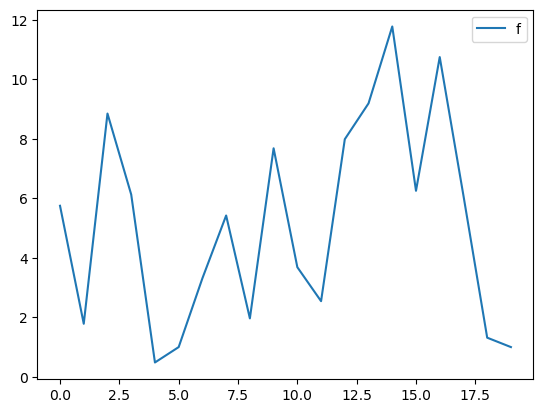

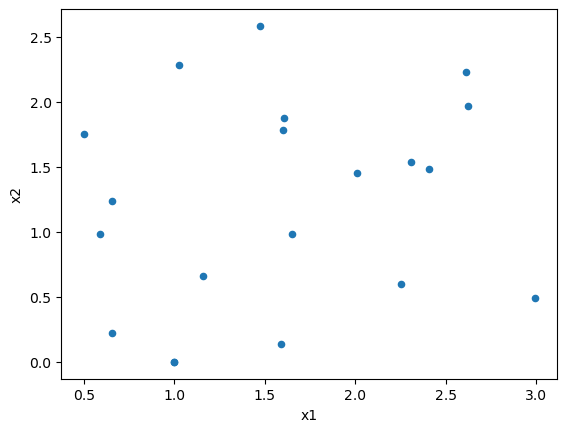

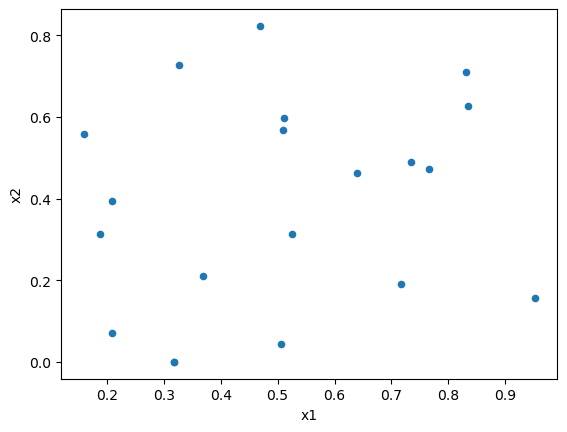

In [16]:
import matplotlib.pyplot as plt

# view objective values
X.data.plot(y=X.vocs.objective_names)

# view variables values
X.data.plot(*X.vocs.variable_names, kind="scatter")

# you can also normalize the variables
X.vocs.normalize_inputs(X.data).plot(*X.vocs.variable_names, kind="scatter")